# Tutorials on running FastHigashi on sn-m3c-seq Lee et al. human PFC dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_m3c_Lee_pfc_500k.JSON"

In [3]:
# initialize the model
wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommend to be False
                      do_rwr=False, # high coverage dataset, set as True would lead to similar results
                      do_col=False,
                      no_col=False)


setting to gpu:1


In [4]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper.chrom_list[0])):
    start = time.time()
    wrapper.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/4238 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 100.99 s


In [5]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper.prep_dataset(batch_norm=True) # when there's a batch_id given in the JSON, it will try to pre-correct batch related coverage bias / off-diag ratio bias
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 4145 bad 93 total: 4238
cache file = /home/rzhang/Higashi/Temp/m3c_Lee_pfc_500k/cache_intra_500000_offdiag_100_.pkl
will do per batch normalization


packing sparse mtx into sparse tensors:   0%|          | 0/22 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/22 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/m3c_Lee_pfc_500k/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.0506174175983833
do_conv False do_rwr False do_col False
recommend_bs_cell [4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145, 4145] pinning memory
packing sparse mtx takes: 75.21 s


In [6]:
wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=3e-4, # on this dataset tol=3e-4 leads to good enough results, but you can run it further with tol=2e-5 or smaller. It's suggested to inspect in the middle training point (See more in the FastHigashi_dipc_Tan_mousebrain_500k.ipynb)
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 0.01


initializing params:   0%|          | 0/22 [00:00<?, ?it/s]

rwr iters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
time elapsed: 20.69
finish init
Starting iteration 0

PARAFAC2 re=5.647 takes 11.4s
Starting iteration 1

PARAFAC2 re=0.458 9.93e-01 variation min9.7e-01 at chrom 20, max1.0e+00 at chrom 1 takes 11.8s
Starting iteration 2

PARAFAC2 re=0.455 1.59e-02 variation min6.4e-03 at chrom 13, max2.7e-02 at chrom 1 takes 12.0s
Starting iteration 3

PARAFAC2 re=0.449 2.66e-02 variation min1.3e-02 at chrom 14, max3.5e-02 at chrom 0 takes 11.5s
Starting iteration 4

PARAFAC2 re=0.445 1.84e-02 variation min1.4e-02 at chrom 12, max2.4e-02 at chrom 0 takes 11.4s
Starting iteration 5

PARAFAC2 re=0.442 9.69e-03 variation min6.8e-03 at chrom 20, max1.3e-02 at chrom 6 takes 11.5s
Starting iteration 6

PARAFAC2 re=0.441 5.36e-03 variation min2.5e-03 at chrom 20, max9.2e-03 at chrom 14 takes 11.0s
Starting iteration 7

PARAFAC2 re=0.440 3.23e-03 variation min1.1e-03 at chrom 20, max5.8e-03 at chrom 14 takes 11.4s
Starting iteration 8

PARAFAC2 re=0.44

In [7]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)

# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


2022-11-28 20:20:08.474711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


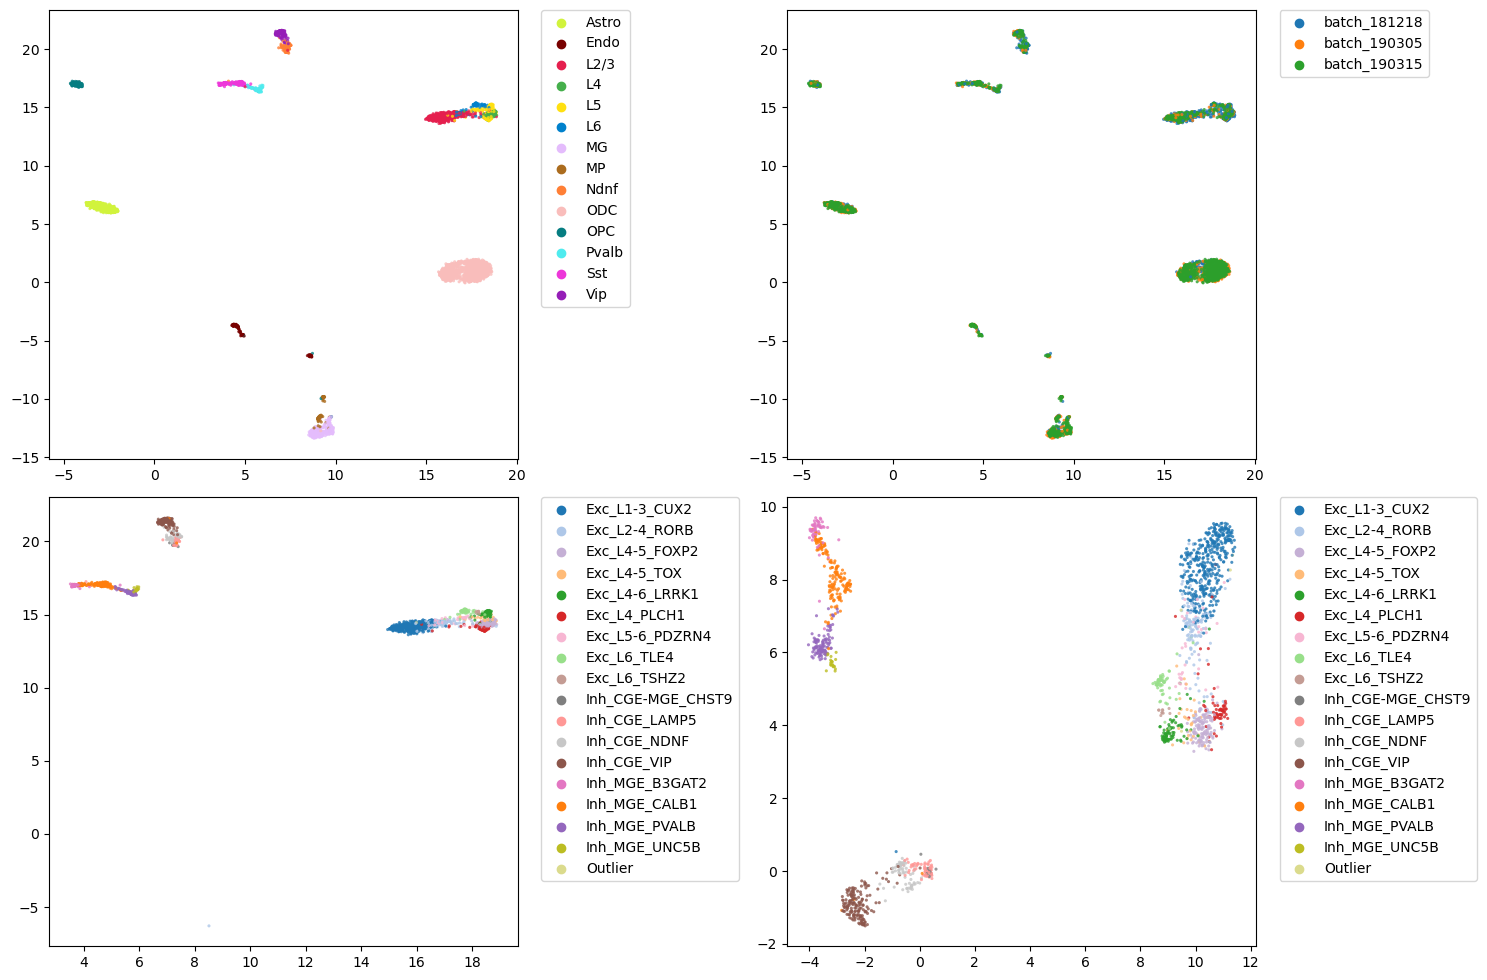

In [8]:
embedding = embed['embed_l2_norm_correct_coverage_fh']

from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


cell_type = wrapper.label_info['cluster label']
batch = wrapper.label_info['batch id']
neuron_subtype = wrapper.label_info['major']


pal1 = {"L2/3": "#e51f4e", "L4": "#45af4b", "L5": "#ffe011", "L6": "#0081cc",
        "Ndnf": "#ff7f35", "Vip": "#951eb7", "Pvalb": "#4febee",
        "Sst": "#ed37d9", "Astro": "#d1f33c", "ODC": "#f9bdbb",
        "OPC": "#067d81", "MG": "#e4bcfc", "MP": "#ab6c1e",
        "Endo": "#780100"}

vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=cell_type, ax=ax, s=5, alpha=0.8, linewidth=0, palette=pal1)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
ax = plt.subplot(2, 2, 2)
sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=batch, ax=ax, s=5, alpha=0.8, linewidth=0)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)


neuron_mask = np.isin(cell_type, np.asarray(['L2/3', 'L4', 'L5', 'L6', 'Ndnf', "Vip", 'Pvalb', 'Sst']))
pal1 = list(sns.color_palette("tab20"))
pal2 = list(sns.color_palette("Set2"))
pal3 = list(sns.color_palette("husl", 12))
pal = pal1 + pal2 + pal3 + pal1
# pal = pal1 + pal3 + pal2
pal_all = pal1 + pal2 + pal3 + pal1 + pal2 + pal3
pal_all = pal_all[:len(np.unique(neuron_subtype[neuron_mask]))]


ax = plt.subplot(2, 2, 3)
sns.scatterplot(x=vec[neuron_mask, 0], y=vec[neuron_mask, 1],
                hue=neuron_subtype[neuron_mask], ax=ax, s=5, alpha=0.8, linewidth=0, palette=pal_all)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)

ax = plt.subplot(2, 2, 4)
vec2 = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding[neuron_mask])
sns.scatterplot(x=vec2[:, 0], y=vec2[:, 1],
                hue=neuron_subtype[neuron_mask], ax=ax, s=5, alpha=0.8, linewidth=0, palette=pal_all)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()

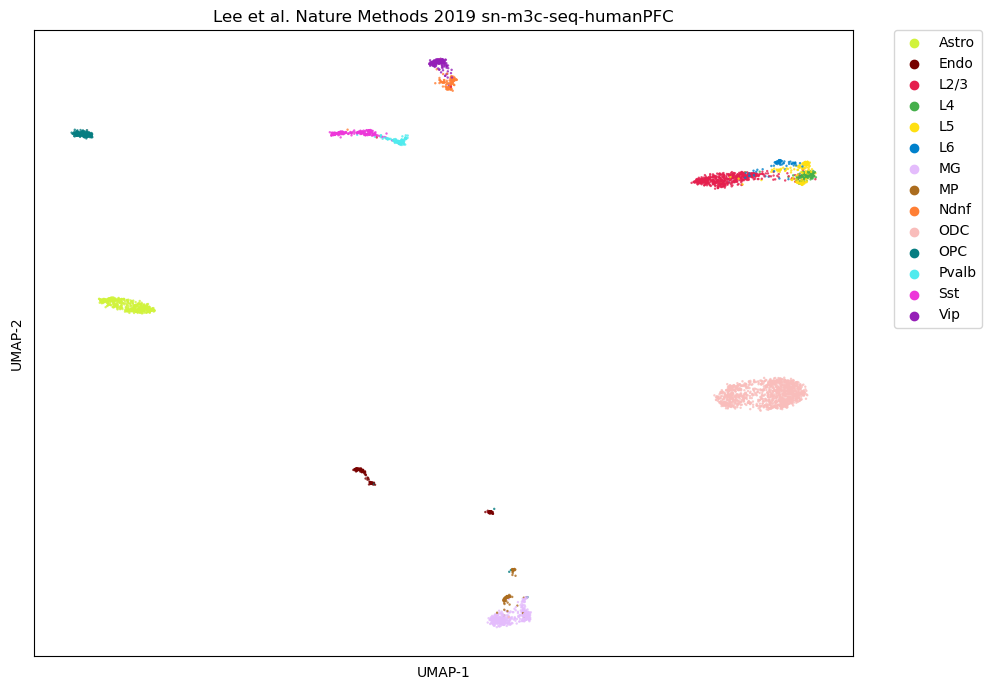

In [9]:
fig = plt.figure(figsize=(10, 7))
col = 'cluster label'
pal1 = {"L2/3": "#e51f4e", "L4": "#45af4b", "L5": "#ffe011", "L6": "#0081cc",
        "Ndnf": "#ff7f35", "Vip": "#951eb7", "Pvalb": "#4febee",
        "Sst": "#ed37d9", "Astro": "#d1f33c", "ODC": "#f9bdbb",
        "OPC": "#067d81", "MG": "#e4bcfc", "MP": "#ab6c1e",
        "Endo": "#780100"}
ax = sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], s=3, alpha=0.8, linewidth=0, palette=pal1)
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title("Lee et al. Nature Methods 2019 sn-m3c-seq-humanPFC")
plt.tight_layout()
plt.show()